In [1]:
import numpy as np                        # Math
from matplotlib import pyplot as plt      # Plots
import h5py

In [2]:
data = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors-2.h5', 'r')

In [3]:
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [4]:
snr = data['snr'][:10000]
iota = data['iota'][:10000]
mtot = data['mtot'][:10000]
q = data['q'][:10000]
det = data['det'][:10000]

[]

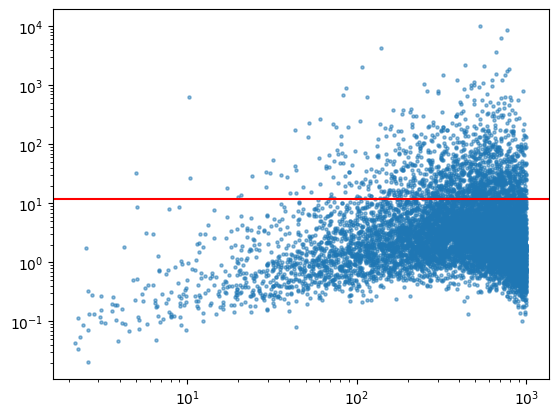

In [5]:
plt.scatter(mtot, snr, s=5, alpha=0.5)
plt.axhline(12, color = 'red')
plt.loglog()

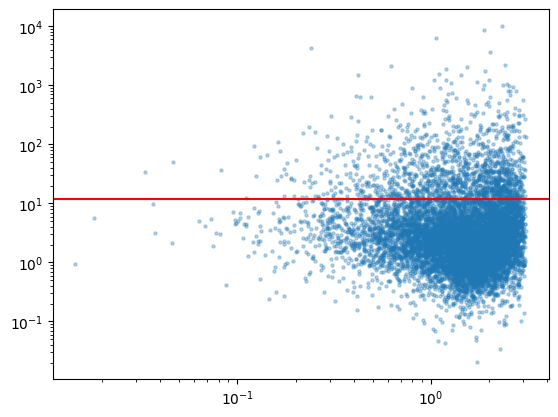

In [6]:
plt.scatter(iota, snr, s=5, alpha=0.3)
plt.axhline(12, color = 'red')
plt.loglog()
plt.show()

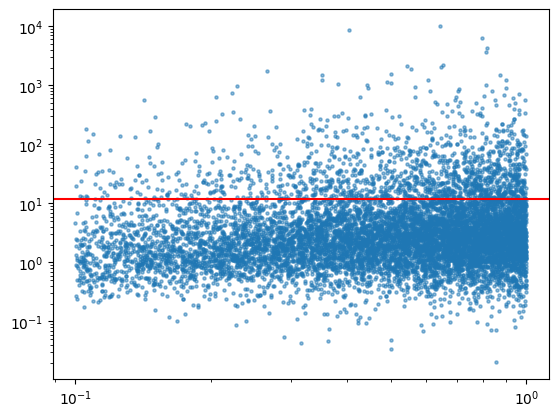

In [7]:
plt.scatter(q, snr, s=5, alpha=0.5)
plt.axhline(12, color = 'red')
plt.loglog()
plt.show()

(10000, 3)
(10000,)
completeness [1. 1. 1.]
contamination [0.01639344 0.01369863 0.01907357]


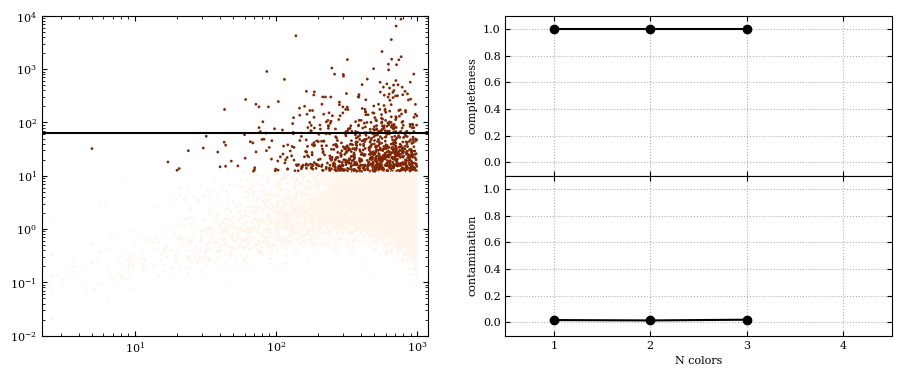

In [24]:
# # Ivezic v2, Figure 9.8, edits by SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import colors

from sklearn.linear_model import LogisticRegression
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#----------------------------------------------------------------------
# get data and split into training & testing sets
Xnew = np.array([snr, mtot, iota]).T
ynew = det
#Xnew = Xnew[np.newaxis,:]  
print(np.shape(Xnew))
print(np.shape(ynew))
(X_train, X_test), (y_train, y_test) = split_samples(Xnew, ynew, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(ynew)
N_st = np.sum(ynew == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Classification
classifiers = []
predictions = []
Ncolors = np.arange(1, Xnew.shape[1] + 1)

for nc in Ncolors:
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)


#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0, 1.2e3)
ylim = (1e-2, 1e4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 4))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(Xnew[-N_plot:, 1], Xnew[-N_plot:, 0], c=ynew[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
#im.set_clim(-0.5, 1)

ax.contour(xx, yy, Z, [0.5], colors='k')

#ax.set_xlim(xlim)
#ax.set_ylim(ylim)

ax.loglog()

#ax.set_xlabel('$u-g$')
#ax.set_ylabel('$g-r$')

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()